# Notebook de test pour séparer en attributs diférents le type de sols

La caractéristique `Bodentyp` regroupe différents types de sols, avec une distinction de 2ème niveau. Les différentes cellules peuvent comporter plusieurs types de sols. Afin de simplifier l'utilisation de cette caractéristique, il a été décidé de séparer cette caractéristique en plusieurs caractéristiques différentes, une par type de sol. De cette manière, le type de sol pourra mieux être exploité dans nos différents tests.

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely import wkt
import matplotlib.pyplot as plt 

In [2]:
csv_path = '../data/processed/processed_enhanced_swiss_data.csv'

# Lecture du GeoDataFrame à partir du CSV
gdf = pd.read_csv(csv_path)

# Applications de paramètres liés à la geometry du GeoDataFrame
gdf['geometry'] = gdf['geometry'].apply(wkt.loads)
gdf = gpd.GeoDataFrame(gdf, geometry='geometry')
gdf.set_crs(epsg=2056, inplace=True)

gdf.head()

,idx,geometry,altitude,TypoCH_NUM,Bodentyp,NAHRSTOFF,WASSERDURC,WASSERSPEI,temperature
0,35,"POLYGON ((2485071.58 1109261.72, 2486071.58 11...",363.5148,62.0,"orthic Luvisol; eutric, calcaric Cambisol",4.0,6.0,4.0,5.2
1,36,"POLYGON ((2485071.58 1110261.72, 2486071.58 11...",358.9348,62.0,"orthic Luvisol; eutric, calcaric Cambisol",4.0,6.0,4.0,5.2
2,261,"POLYGON ((2486071.58 1109261.72, 2487071.58 11...",415.6684,62.0,"eutric, dystric Cambisol; eutric Regosol; spod...",4.0,4.0,4.0,5.3
3,262,"POLYGON ((2486071.58 1110261.72, 2487071.58 11...",368.5936,62.0,"eutric, dystric Cambisol; eutric Regosol; spod...",4.0,4.0,4.0,5.3
4,263,"POLYGON ((2486071.58 1111261.72, 2487071.58 11...",352.9472,82.0,"orthic Luvisol; eutric, calcaric Cambisol",4.0,6.0,4.0,5.3


In [3]:
# Fonction pour extraire les types de sols et leurs qualificatifs
def extract_soil_types(bodentyp):
    soils = bodentyp.split(";")

    # Aucune valeur a extraire pour les valeurs inconnues
    if soils == ['-'] :
        return {}

    results = {}
    for soil in soils :
        
        qualificatifs = []
        
        parts = soil.rsplit(", ", 1)
        last_part = parts[-1].strip().split(" ", 1)

        # Traitement du cas de calcaric (jura) Cambisol
        if last_part[-1].strip().startswith("(") and not last_part[-1].endswith(")"):
            last_part = parts[-1].strip().split(" ", 2)
            qualificatifs = [q.strip() for q in (parts[:-1] + [" ".join([last_part[0], last_part[1]])])]
        else : 
            qualificatifs = [q.strip() for q in (parts[:-1] + last_part[:-1])]
            
        soil_type = last_part[-1].strip()
        
        # Traitement du cas Rendzina (Jura)
        if last_part[-1].startswith("(") and last_part[-1].endswith(")"):
            soil_type = " ".join(last_part)
            qualificatifs = parts[: -1]
            
        results[soil_type.strip()] = qualificatifs    
    return results

In [4]:
# Appliquer la fonction à la colonne "Bodentyp"
gdf["Soil_data"] = gdf["Bodentyp"].apply(extract_soil_types)

# Identifier tous les types de sols présents dans le dataset
all_soil_types = set()
for soil_data in gdf["Soil_data"]:
    all_soil_types.update(soil_data.keys())  # Les types de sols sont des clés de dictionnaire

# Ajouter une colonne pour chaque type de sol
for soil_type in all_soil_types:
    column_name = f"Bodentyp_{soil_type.replace(' ', '_')}"
    gdf[column_name] = gdf["Soil_data"].apply(lambda x: ", ".join(x.get(soil_type, ["-"])))

# Supprimer les colonnes intermédiaires
gdf.drop(columns=["Bodentyp", "Soil_data"], inplace=True)

pd.set_option('display.max_columns', None)
gdf.head()

,idx,geometry,altitude,TypoCH_NUM,NAHRSTOFF,WASSERDURC,WASSERSPEI,temperature,Bodentyp_Rendzina_(Jura),Bodentyp_Cambisol,Bodentyp_Histosol,Bodentyp_Lithosol,Bodentyp_Rendzina,Bodentyp_Cambisol_(feinkörnige_Variante),Bodentyp_Regosol,Bodentyp_Fluvisol,Bodentyp_Gleysol,Bodentyp_Ranker,Bodentyp_Podzol,Bodentyp_Luvisol
0,35,"POLYGON ((2485071.58 1109261.72, 2486071.58 11...",363.5148,62.0,4.0,6.0,4.0,5.2,-,"eutric, calcaric",-,-,-,-,-,-,-,-,-,orthic
1,36,"POLYGON ((2485071.58 1110261.72, 2486071.58 11...",358.9348,62.0,4.0,6.0,4.0,5.2,-,"eutric, calcaric",-,-,-,-,-,-,-,-,-,orthic
2,261,"POLYGON ((2486071.58 1109261.72, 2487071.58 11...",415.6684,62.0,4.0,4.0,4.0,5.3,-,spododystric,-,-,-,-,eutric,-,-,-,-,-
3,262,"POLYGON ((2486071.58 1110261.72, 2487071.58 11...",368.5936,62.0,4.0,4.0,4.0,5.3,-,spododystric,-,-,-,-,eutric,-,-,-,-,-
4,263,"POLYGON ((2486071.58 1111261.72, 2487071.58 11...",352.9472,82.0,4.0,6.0,4.0,5.3,-,"eutric, calcaric",-,-,-,-,-,-,-,-,-,orthic


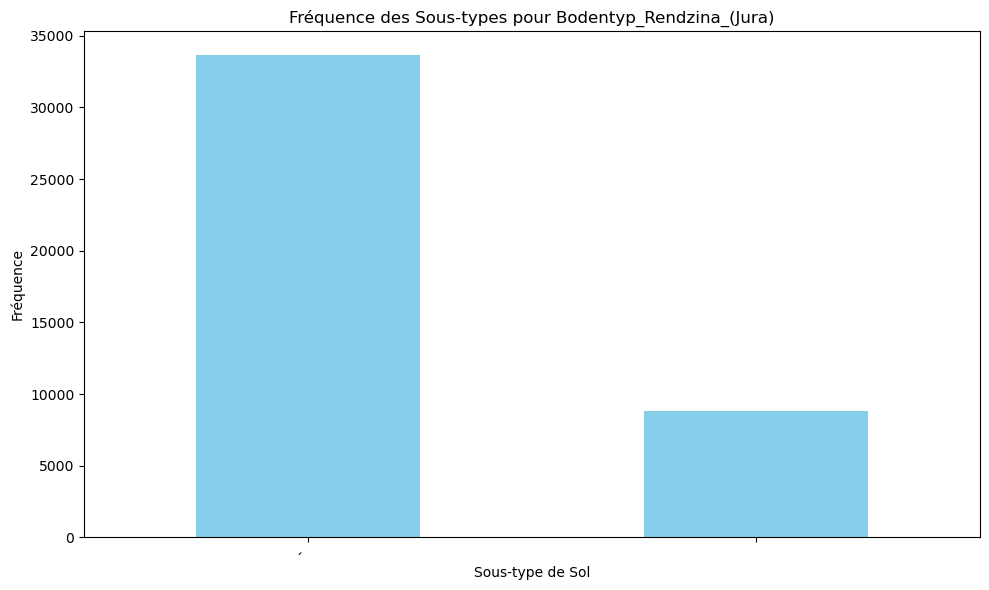

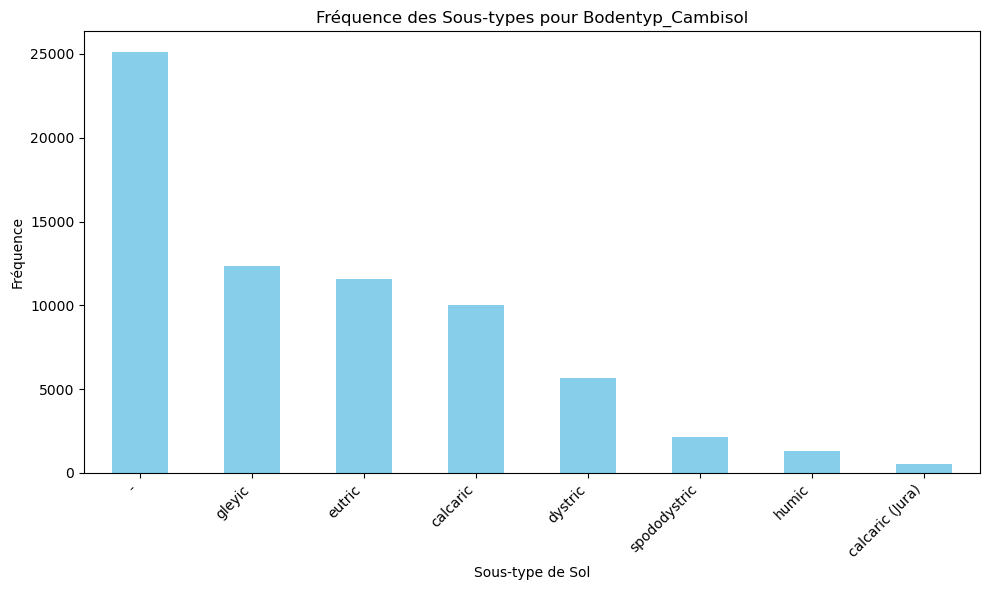

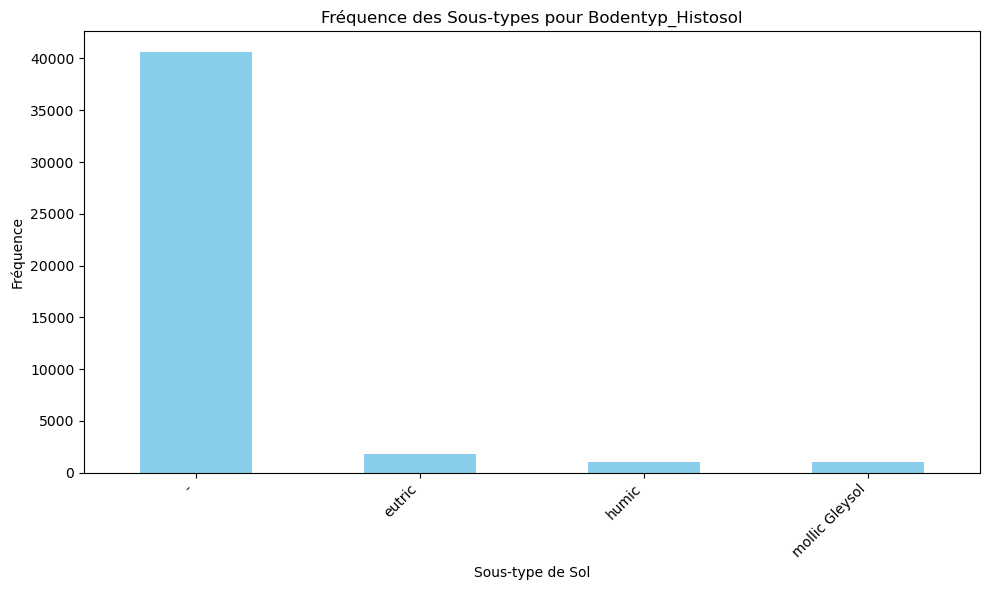

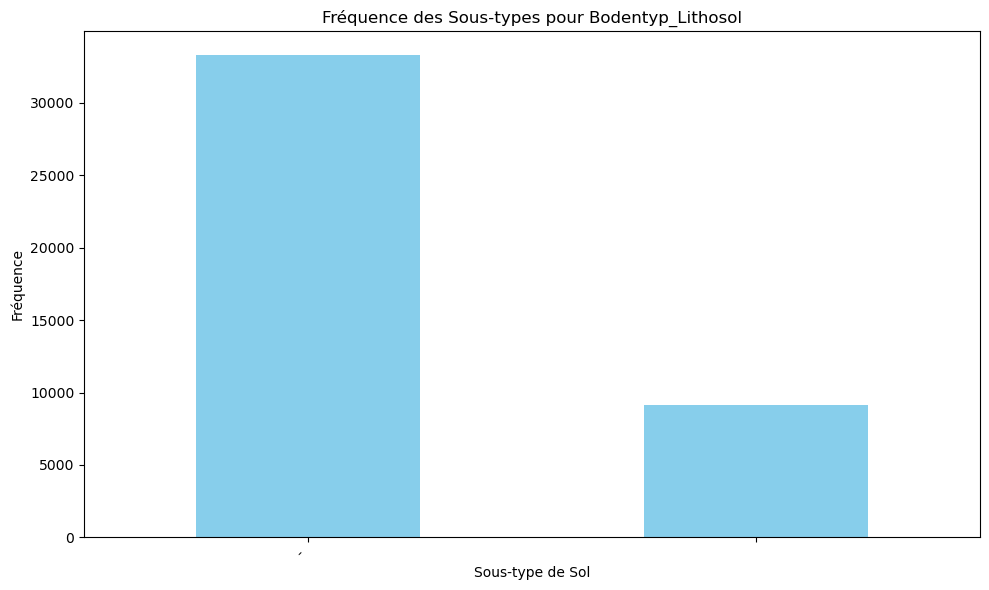

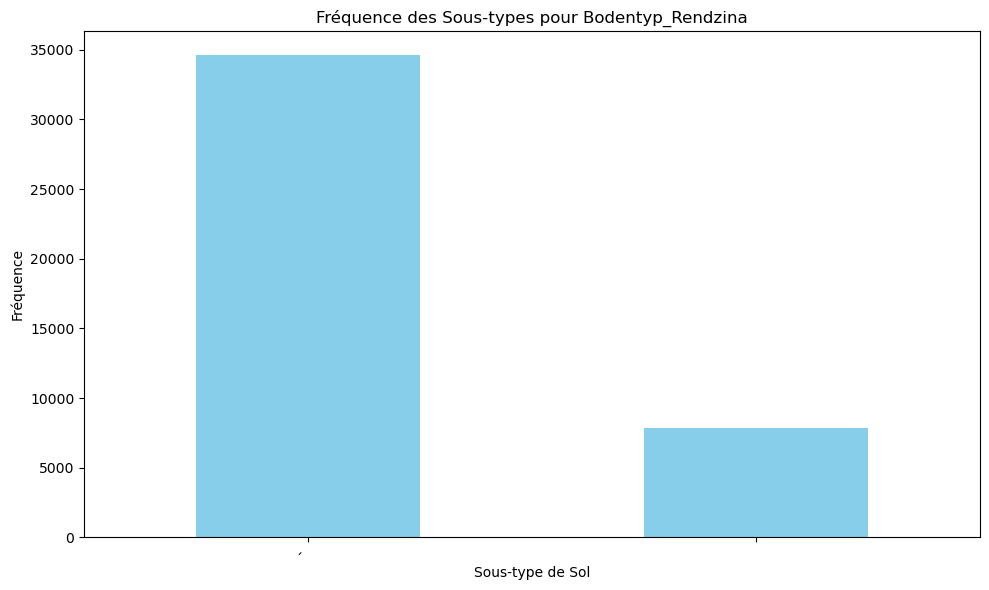

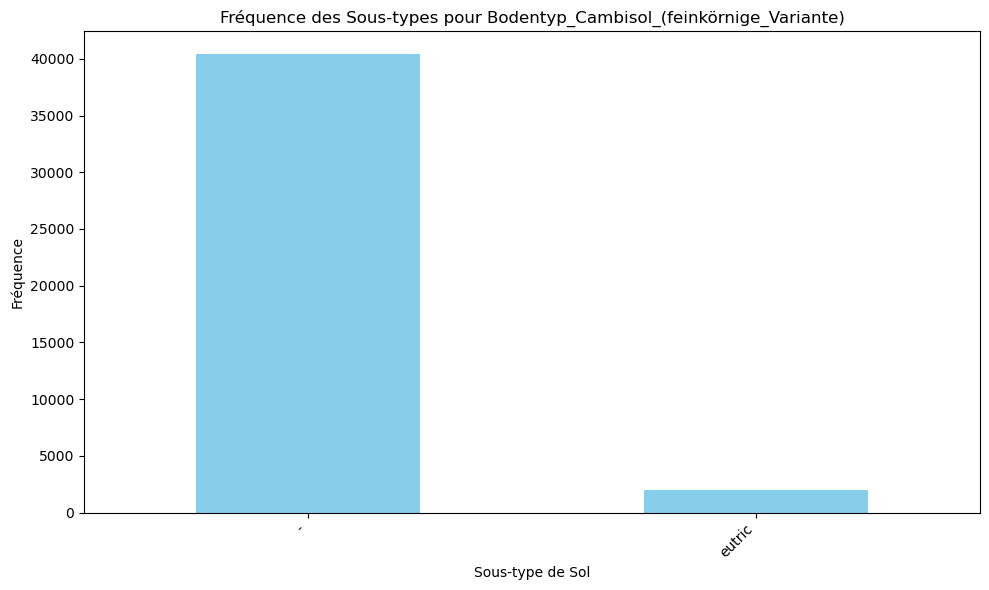

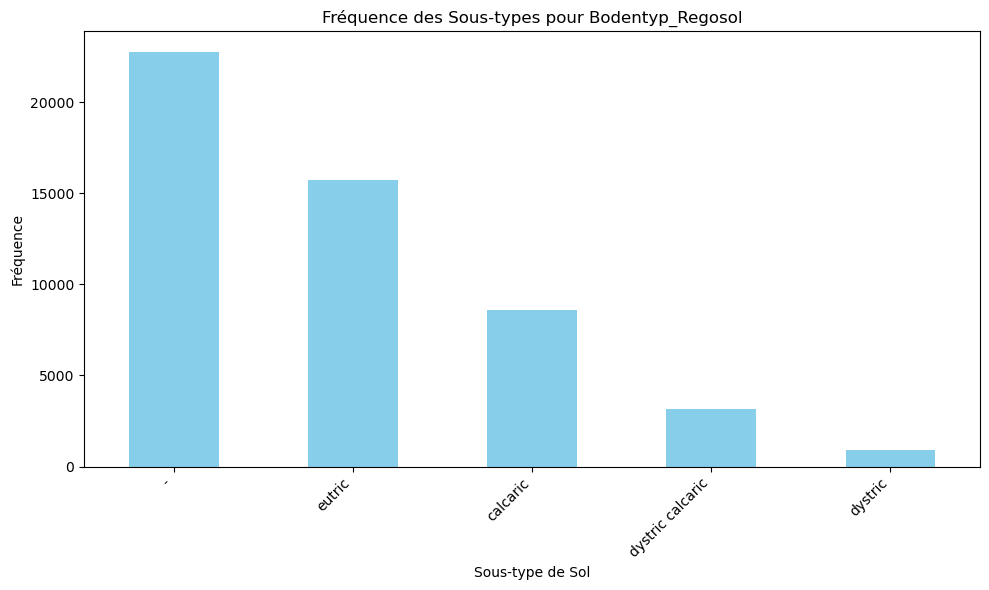

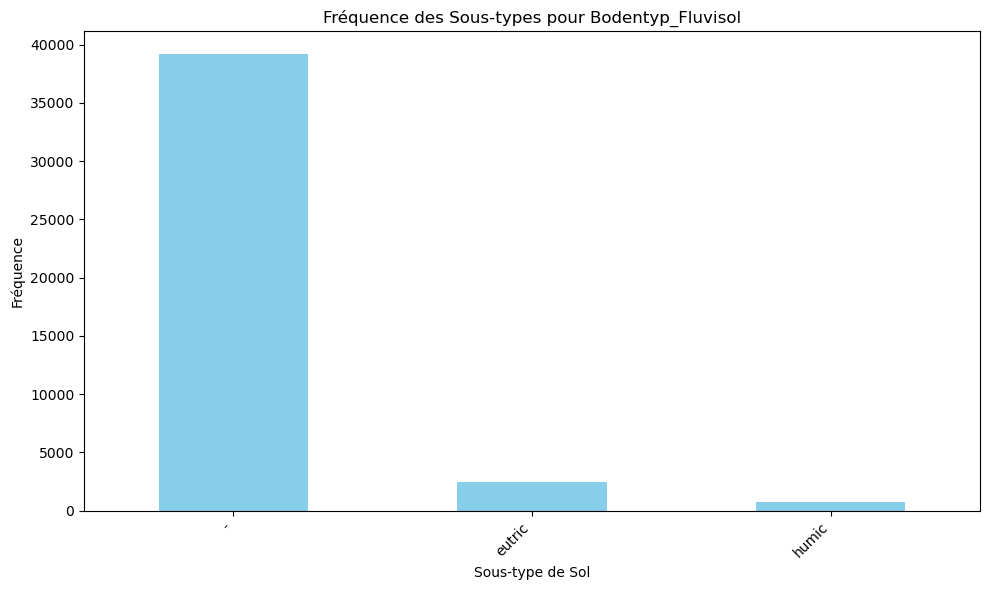

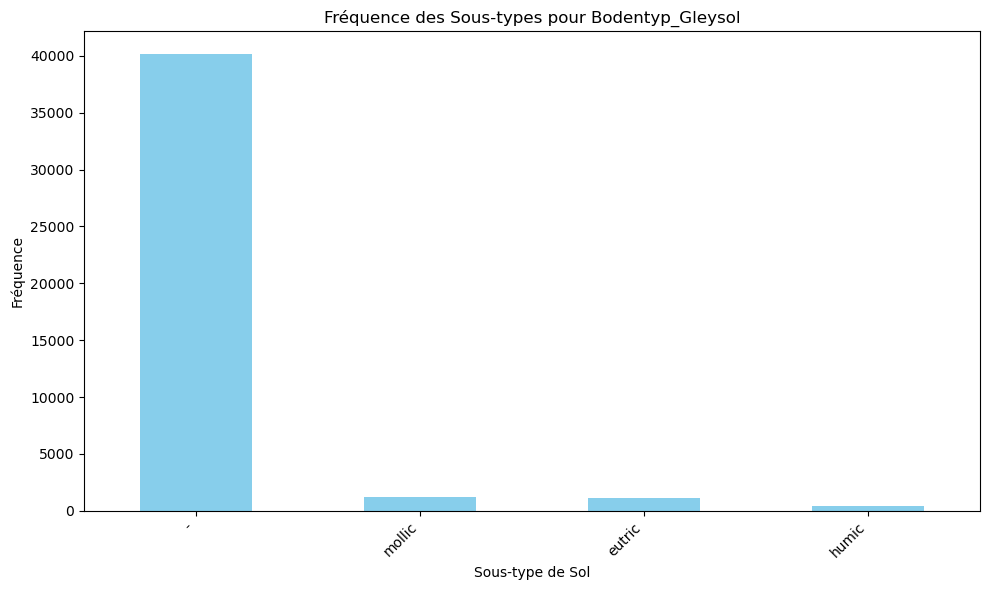

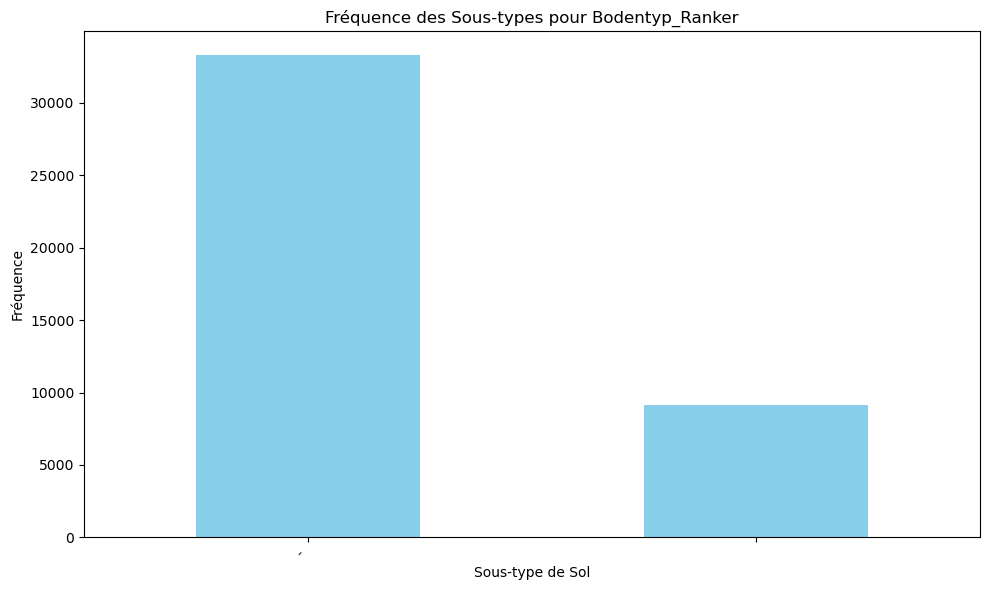

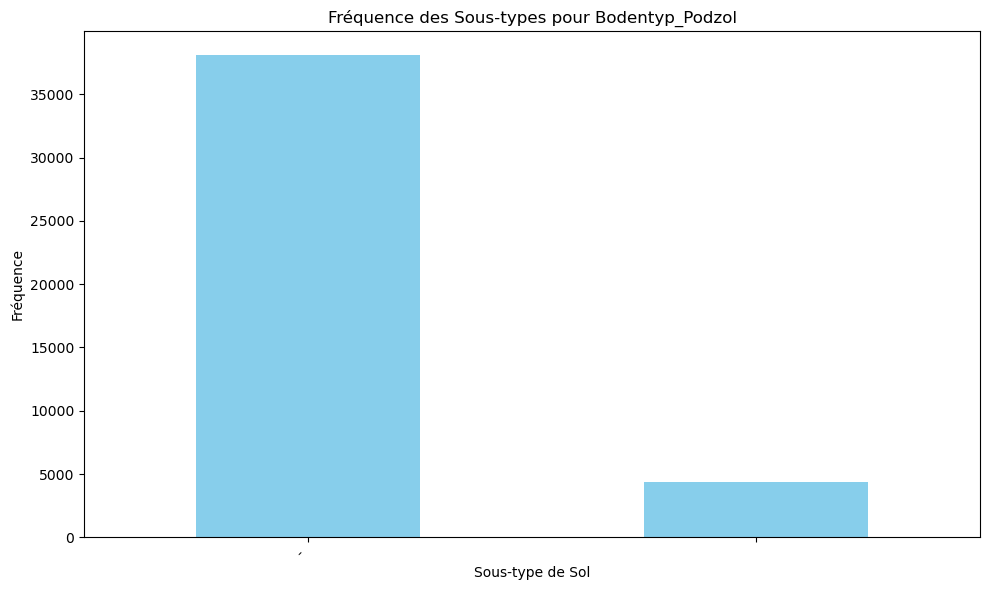

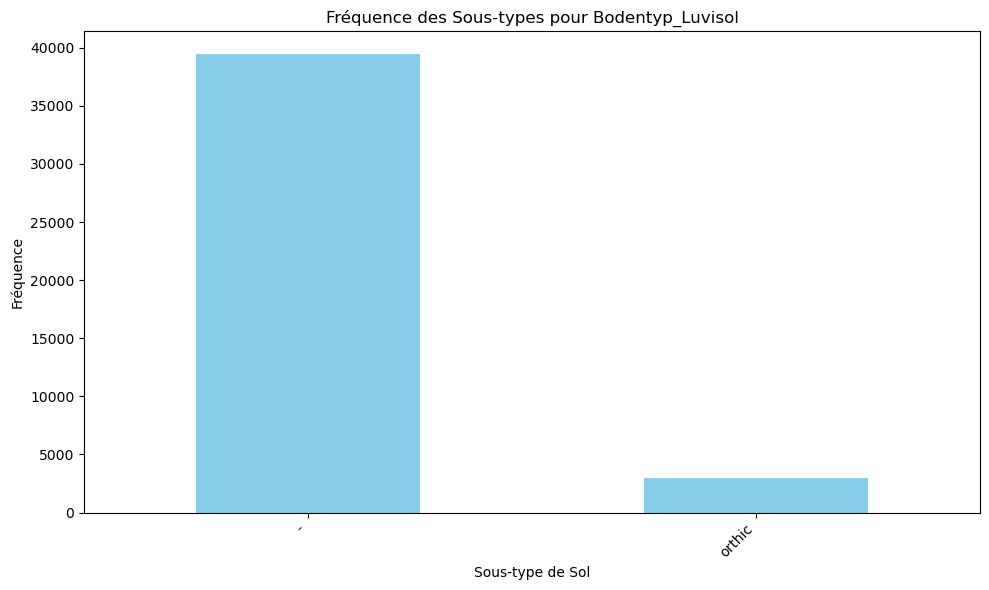

In [5]:
bodentyp_columns = [col for col in gdf.columns if col.startswith('Bodentyp_')]

# Créer les histogrammes pour chaque type de sol
for column in bodentyp_columns:
    # Récupérer tous les sous-types de sols
    soil_subtypes = gdf[column].str.split(', ').explode()
    
    # Compter la fréquence de chaque sous-type
    soil_subtypes_count = soil_subtypes.value_counts()

    # Vérifier s'il y a des sous-types après explosion
    if soil_subtypes.empty:
        print(f"Aucun sous-type trouvé pour {column}. Aucun histogramme généré.")
        continue

    # Créer un histogramme pour ce type de sol
    plt.figure(figsize=(10, 6))
    soil_subtypes_count.plot(kind='bar', color='skyblue')

    # Paramètres d'affichage
    plt.title(f'Fréquence des Sous-types pour {column}')
    plt.xlabel('Sous-type de Sol')
    plt.ylabel('Fréquence')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()

    # Afficher l'histogramme
    plt.show()